In [28]:
%matplotlib inline

# Latest GEOS-16 satellite image

Python script to plot true color image from the GOES-16 (east; Atlantic) or GEOS-17 (west; Pacific) Advanced Baseline Imager (ABI) on a map.
Have a look at available satellite products here: https://thredds.ucar.edu/thredds/idd/satellite.html

NOAA provides the reflectance & brightness temperatures precomputed as the Level 2 (L2) product. Here, we are going to use to  ABI Cloud and Moisture Imagery for the CONUS (North America) region.

I followed the tutorial of Brian Blaylock found [here](https://github.com/blaylockbk/pyBKB_v2/blob/master/BB_goes16/mapping_GOES16_data.ipynb).

In [7]:
# =======
# import the libraries
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import patheffects
import matplotlib.pyplot as plt
import metpy  # noqa: F401
import numpy as np
from siphon.catalog import TDSCatalog
import xarray as xr
from xarray.backends import NetCDF4DataStore
from scipy import interpolate

In [51]:
%%time
# =======
# Get the most recent satellite image

def open_dataset(sector, date, channel, idx):
    """
    Open and return a netCDF Dataset object for a given sector, date, channel, and image index
    of GOES-16 data from THREDDS.
    """
    cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/'
             '{}/Channel{:02d}/{}/catalog.xml'.format(sector, channel, date)) 
    dataset = cat.datasets[idx]
    print(dataset.access_urls['OPENDAP'])
    ds = xr.open_dataset(dataset.access_urls['OPENDAP'])
    return ds

# =======
# define parameters
sector = 'CONUS'
date = datetime.strftime(datetime.utcnow(), '%Y%m%d') 
date = 'current' # or date = 'YYYYMMDD' for last two weeks 
idx = -1    # most recent
# to get exact time of the current date
idx = int((datetime.utcnow() - datetime.strptime('20200118_1621', '%Y%m%d_%H%M')).seconds/60/10)     

# =======
# get Red (Band 2), Blue (Band 1) and Green (Band 3) as RGB and clean IR (Band 13) for nighttime
# I get sometimes Runtime Error "netCDF not found"--> loosing connection to Server

with open_dataset(sector, date, 1, idx) as blue_ds:
    blue_data = blue_ds['Sectorized_CMI'].data

with open_dataset(sector, date, 3, idx) as green_ds:
    green_data = green_ds['Sectorized_CMI'].data
    # Get projection and coordinates
    dat = green_ds.metpy.parse_cf('Sectorized_CMI')
    geos = dat.metpy.cartopy_crs
    x = dat.x
    y = dat.y
    x_green = green_ds['x'].data
    y_green = green_ds['y'].data
    
with open_dataset(sector, date, 2, idx) as red_ds:
    # Band 2 (Red Visible) has different resolution while Band 1 (Blue Visible) and Band 3 (Veggie IR) are 1000-meter resolution: Need to resample!
    #red_data = red_ds['Sectorized_CMI'].reindex(x=x, y=y, method='nearest')
    red_data = red_ds['Sectorized_CMI'].data
    x_red = red_ds['x'].data
    y_red = red_ds['y'].data

with open_dataset(sector, date, 13, idx) as cleanIR_ds:
    # Band 13 (IR) has different resolution while Band 1 (Blue Visible) and Band 3 (Veggie IR) are 1000-meter resolution: Need to resample!
    #cleanIR_data = cleanIR_ds['Sectorized_CMI'].reindex(x=x, y=y, method='nearest')
    cleanIR_data = cleanIR_ds['Sectorized_CMI'].data
    x_IR = cleanIR_ds['x'].data
    y_IR = cleanIR_ds['y'].data

# ======= Get Full Disk 
#cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudTopTemperature/FullDisk/current/catalog.xml')
#ds = scat.datasets[-1]
#print(ds)
#print(ds.access_urls)
#ds = ds.remote_access(use_xarray=True)

https://thredds.ucar.edu/thredds/dodsC/satellite/goes/east/products/CloudAndMoistureImagery/FullDisk/Channel01/current/OR_ABI-L2-CMIPF-M6C01_G16_s20200181610190_e20200181610190_c20200181610190.nc
https://thredds.ucar.edu/thredds/dodsC/satellite/goes/east/products/CloudAndMoistureImagery/FullDisk/Channel03/current/OR_ABI-L2-CMIPF-M6C03_G16_s20200181610190_e20200181610190_c20200181610190.nc
https://thredds.ucar.edu/thredds/dodsC/satellite/goes/east/products/CloudAndMoistureImagery/FullDisk/Channel02/current/OR_ABI-L2-CMIPF-M6C02_G16_s20200181610190_e20200181610190_c20200181610190.nc
https://thredds.ucar.edu/thredds/dodsC/satellite/goes/east/products/CloudAndMoistureImagery/FullDisk/Channel13/current/OR_ABI-L2-CMIPF-M6C13_G16_s20200181610190_e20200181610190_c20200181610190.nc
CPU times: user 1.57 s, sys: 421 ms, total: 1.99 s
Wall time: 1min 24s


In [52]:
# =======
# remapping Band 2 and Band 13

# Band 2 (Red Visible) and Band 13 (IR) have other resolution, while Band 1 (Blue Visible) and Band 3 (Veggie IR) are 1,000-meter resolution. In order to combine the different bands into an RGB image we will first resample all bands to 1000-meter resolution.


def regrid(data, in_x, in_y, out_x, out_y):  
    """
    Remapping function: Interpolate the channel to the same grid as another channel.
    """
    #correct first and last entry so that not out of bounds
    out_x[0] = in_x[0]; out_x[-1] = in_x[-1]
    out_y[0] = in_y[0]; out_y[-1] = in_y[-1]
    
    interpolating_function = interpolate.RegularGridInterpolator((in_y[::-1], in_x), data)
    yv, xv = np.meshgrid(out_x, out_y[::-1])
    return interpolating_function((xv, yv))

red_new = regrid(red_data, x_red, y_red, x_green, y_green)
cleanIR_new = regrid(cleanIR_data, x_IR, y_IR, x_green, y_green)

In [53]:
# =====
# prepare True color image

# Apply range limits for each channel. RGB values must be between 0 and 1
red = np.clip(red_new, 0, 1)
green = np.clip(green_data, 0, 1)
blue = np.clip(blue_data, 0, 1)

# Apply a gamma correction to the image to correct ABI detector brightness
gamma = 0.45
red = np.power(red, gamma)
green = np.power(green, gamma)
blue = np.power(blue, gamma)

# get "true" green
green_true = 0.45 * red + 0.45 * blue + 0.1 * green
green_true = np.clip(green_true, 0, 1)

# The RGB array with the raw veggie band or with the true green band
RGB = np.dstack([red, green, blue])    # The addition of the three channels results in a color image.

# =======
# prepare nighttime IR when dark

# Normalize the channel between a range
cleanIR = (cleanIR_new-90)/(313-90)
cleanIR = np.clip(cleanIR, 0, 1)

# Invert colors so that cold clouds are white
cleanIR = 1 - cleanIR

# Lessen the brightness of the coldest clouds so they don't appear so bright when we overlay it on the true color image
cleanIR = cleanIR/1.4

# create grey image
RGB_cleanIR = np.dstack([cleanIR, cleanIR, cleanIR])

# =======
# Add contrast correction to RGB
def contrast_correction(color, contrast):
    """
    Modify the contrast of an RGB
    See:
    https://www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/

    Input:
        color    - an array representing the R, G, and/or B channel
        contrast - contrast correction level
    """
    F = (259*(contrast + 255))/(255.*259-contrast)
    COLOR = F*(color-.5)+.5
    COLOR = np.clip(COLOR, 0, 1)  # Force value limits 0 through 1.
    return COLOR

# Amount of contrast
contrast_amount = 105
RGB = contrast_correction(RGB, contrast_amount)

# =======
# combining RGB and nigh IR 
# Maximize the RGB values between the True Color Image and Clean IR image
RGB_ColorIR = np.dstack([np.maximum(RGB[:, :, 0], cleanIR), 
                         np.maximum(RGB[:, :, 1], cleanIR),
                         np.maximum(RGB[:, :, 2], cleanIR)])

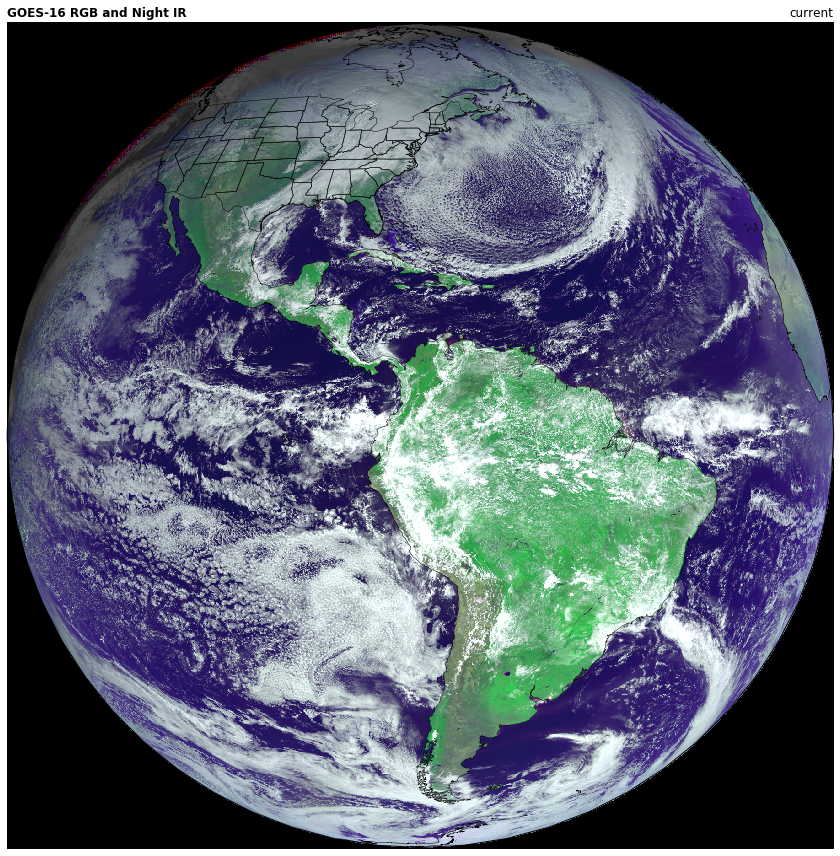

In [56]:
# Start figure and set up projection on axes for plotting

fig = plt.figure(figsize=(15, 12))
# Create axis with Geostationary projection
ax = fig.add_subplot(1, 1, 1, projection=geos)

# Plot gamma correction visible reflectance values
ax.imshow(RGB_ColorIR,extent=(x.min(),x.max(),y.min(),y.max()),origin='upper',transform=geos)

# Add Coastlines and States
ax.coastlines(resolution='50m', color='black', linewidth=0.5)
ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
#ax.set_extent([-90, -30, 0, 90], ccrs.PlateCarree())

# Add Title
plt.title('GOES-16 RGB and Night IR', loc='left', fontweight='semibold', fontsize=12)
plt.title('{}'.format(date), loc='right')

plt.tight_layout()
plt.show()